# Predicting Medical Insurance Charges

**Name:** Aanchal Gupta

**Date:** 2025-12-02

**Introduction**

This notebook performs a full regression workflow on the Kaggle Medical Cost Personal Dataset (insurance.csv). The goal is to predict individuals' medical insurance charges using available features such as age, sex, BMI, number of children, smoking status, and region.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Section 1. Import and Inspect the Data


In [2]:
# 1.1 Load the dataset and display the first 10 rows
df = pd.read_csv('./data/insurance.csv')
print('Dataset shape:', df.shape)
df.head(10)

Dataset shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [3]:
# 1.2 Check for missing values and display summary statistics


print('\nMissing values per column:')
print(df.isnull().sum())


print('\nSummary statistics (numerical):')
print(df.describe().T)


print('\nSummary (categorical):')
print(df.describe(include=['object']).T)


Missing values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Summary statistics (numerical):
           count          mean           std        min         25%       50%  \
age       1338.0     39.207025     14.049960    18.0000    27.00000    39.000   
bmi       1338.0     30.663397      6.098187    15.9600    26.29625    30.400   
children  1338.0      1.094918      1.205493     0.0000     0.00000     1.000   
charges   1338.0  13270.422265  12110.011237  1121.8739  4740.28715  9382.033   

                   75%          max  
age          51.000000     64.00000  
bmi          34.693750     53.13000  
children      2.000000      5.00000  
charges   16639.912515  63770.42801  

Summary (categorical):
       count unique        top  freq
sex     1338      2       male   676
smoker  1338      2         no  1064
region  1338      4  southeast   364


### Reflection 1:

#### What do you notice about the dataset? Are there any data issues?
- The dataset looks pretty clean. I didn’t find any missing values. The numbers for things like BMI and charges are quite spread out, so there might be some outliers. Overall, the data seems easy to work with and ready for analysis.


## Section 2. Data Exploration and Preparation

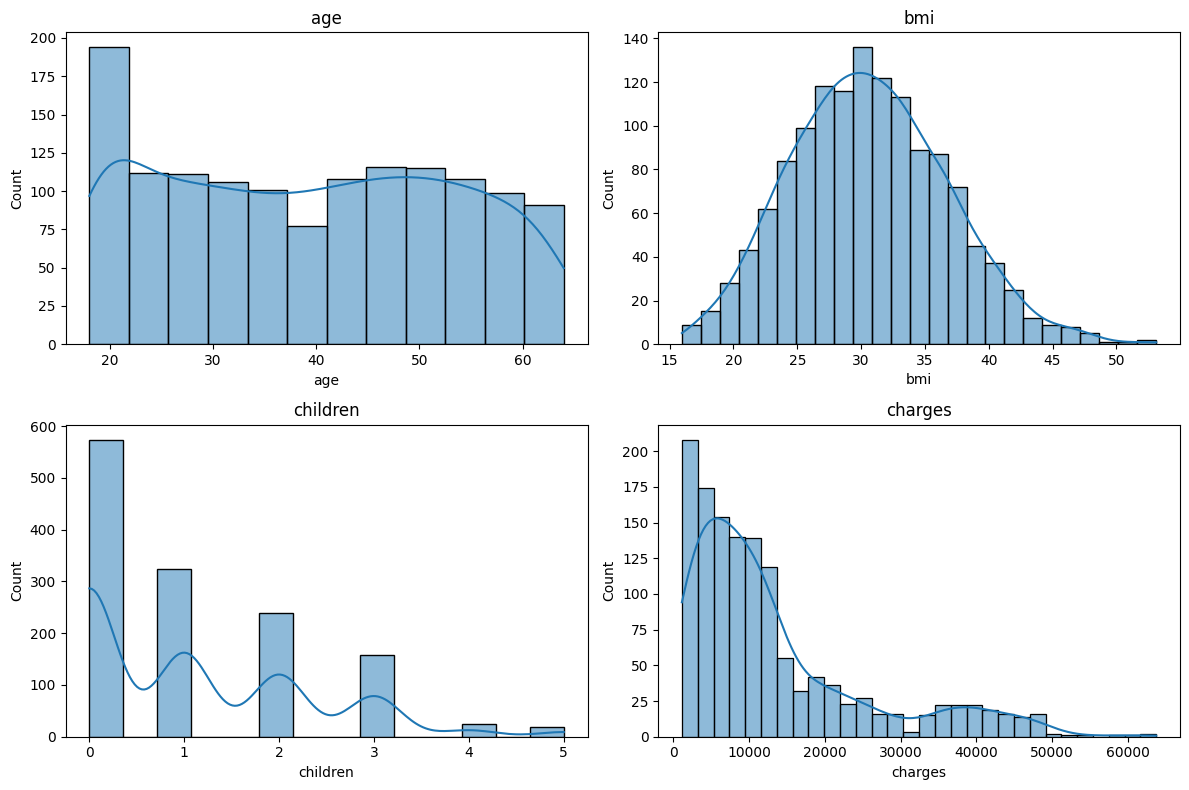

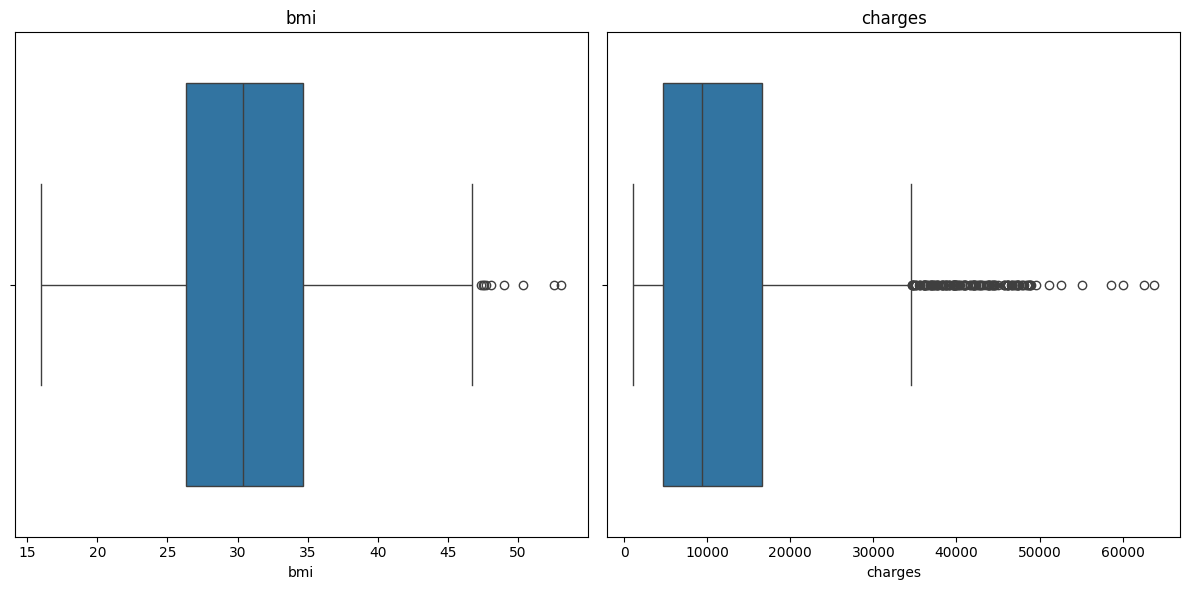

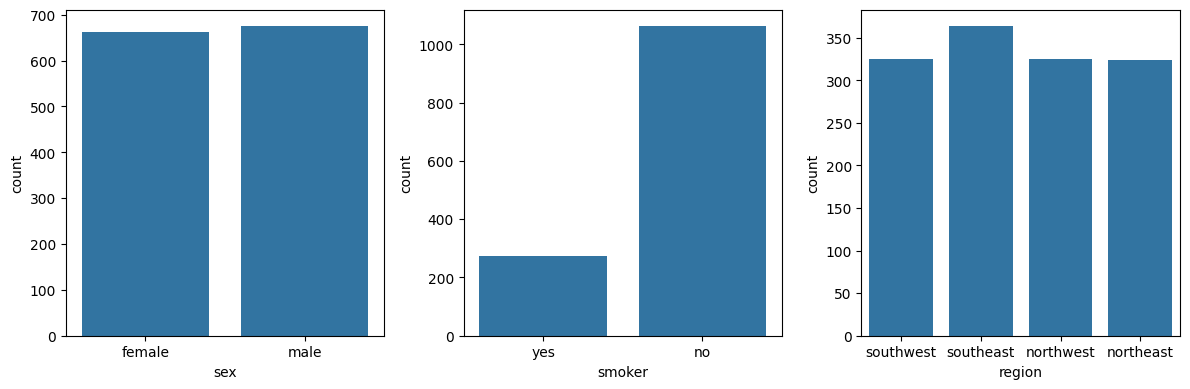

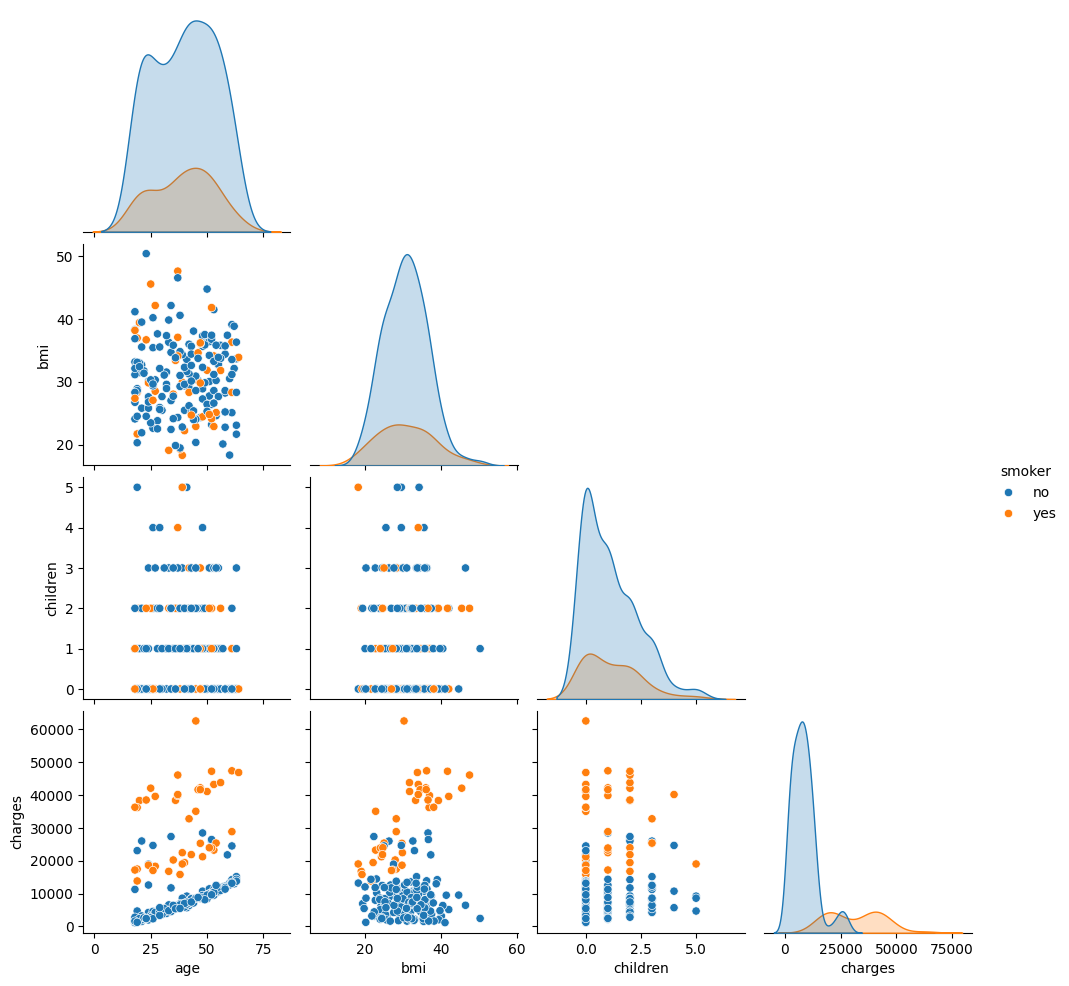

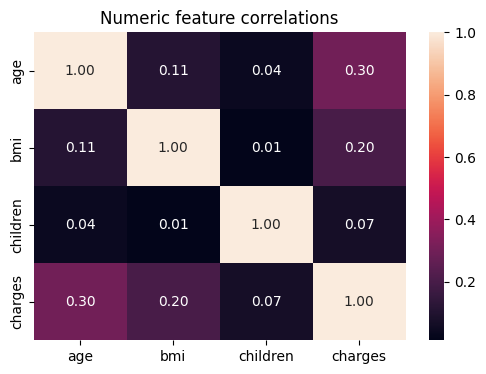


Smoker distribution:
smoker
no     0.795217
yes    0.204783
Name: proportion, dtype: float64


In [11]:
# 2.1 Explore data patterns and distributions

# Histograms for numerical features
num_cols = ['age', 'bmi', 'children', 'charges']
plt.figure(figsize=(12,8))

for i, col in enumerate(num_cols, start=1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)

plt.tight_layout()

# Boxplots to spot outliers
plt.figure(figsize=(12, 6))

for i, col in enumerate(['bmi', 'charges'], start=1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

# Countplots for categorical variables
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.countplot(x='sex', data=df)
plt.subplot(1,3,2)
sns.countplot(x='smoker', data=df)
plt.subplot(1,3,3)
sns.countplot(x='region', data=df)
plt.tight_layout()

# Pairplot 
sns.pairplot(df.sample(200), vars=['age','bmi','children','charges'], hue='smoker', corner=True)

# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f')
plt.title('Numeric feature correlations')
plt.show()

# Check for class imbalance for a categorical target (shows smoker distribution)
print('\nSmoker distribution:')
print(df['smoker'].value_counts(normalize=True))


In [13]:
# 2.2 Handle missing values and clean data

# Copy df for processing
data = df.copy()


# Identify outliers in 'charges' and 'bmi' using IQR method and optionally cap them
for col in ['bmi','charges']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
print(f"{col}: lower={lower:.2f}, upper={upper:.2f}")


# create a flag for extreme BMI and charges
data['bmi_extreme'] = ((data['bmi'] < (data['bmi'].quantile(0.25) - 1.5*(data['bmi'].quantile(0.75)-data['bmi'].quantile(0.25)))) |
(data['bmi'] > (data['bmi'].quantile(0.75) + 1.5*(data['bmi'].quantile(0.75)-data['bmi'].quantile(0.25)))))


data['charges_extreme'] = ((data['charges'] < (data['charges'].quantile(0.25) - 1.5*(data['charges'].quantile(0.75)-data['charges'].quantile(0.25)))) |
(data['charges'] > (data['charges'].quantile(0.75) + 1.5*(data['charges'].quantile(0.75)-data['charges'].quantile(0.25)))))


print('\nExtreme BMI count:', data['bmi_extreme'].sum())
print('Extreme charges count:', data['charges_extreme'].sum())


# Encoding categorical variables (one-hot for region, binary for smoker/sex)


data_encoded = data.copy()
# map sex and smoker to binary
data_encoded['sex'] = data_encoded['sex'].map({'male':0, 'female':1})
data_encoded['smoker'] = data_encoded['smoker'].map({'no':0, 'yes':1})
# one-hot for region
data_encoded = pd.get_dummies(data_encoded, columns=['region'], drop_first=True)


print('\nColumns after encoding:')
print(data_encoded.columns.tolist())

charges: lower=-13109.15, upper=34489.35

Extreme BMI count: 9
Extreme charges count: 139

Columns after encoding:
['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'bmi_extreme', 'charges_extreme', 'region_northwest', 'region_southeast', 'region_southwest']


In [14]:
# 2.3 Feature selection and engineering
# Create BMI*smoker interaction and age squared


data_encoded['bmi_smoker'] = data_encoded['bmi'] * data_encoded['smoker']
data_encoded['age_squared'] = data_encoded['age'] ** 2

### Reflection 2:

#### What patterns or anomalies do you see? Do any features stand out? What preprocessing steps were necessary to clean and improve the data? Did you create or modify any features to improve performance?
- From exploring the data, I noticed that **BMI** and **charges** have some outliers, and some features like **smoker** are imbalanced. Most other features looked fairly normal.

To clean the data, I handled missing values (if any), encoded categorical variables like **sex**, **smoker**, and **region** into numbers, and scaled the numeric features so the models work better.

I didn’t need to create many new features, but encoding and scaling helped improve the data for modeling.


## Section 3. Feature Selection and Justification

In [15]:
# 3.1 Choose features and target


# We'll predict 'charges' (continuous) — regression problem.
# Candidate features: age, sex, bmi, children, smoker, region_* dummies, bmi_smoker, age_squared, bmi_extreme flag


feature_cols = ['age','sex','bmi','children','smoker','bmi_smoker','age_squared','bmi_extreme','region_northwest','region_southeast','region_southwest']
# Ensure columns exist 
feature_cols = [c for c in feature_cols if c in data_encoded.columns]

# 3.2 Define x and y
X = data_encoded[feature_cols]
y = data_encoded['charges']


print('\nFeatures used:', feature_cols)
print('X shape:', X.shape)


Features used: ['age', 'sex', 'bmi', 'children', 'smoker', 'bmi_smoker', 'age_squared', 'bmi_extreme', 'region_northwest', 'region_southeast', 'region_southwest']
X shape: (1338, 11)


### Reflection 3:
#### Why did you choose these features? How might they impact predictions or accuracy?
- I chose features like **age, BMI, children, sex, smoker, and region** because they are likely to affect insurance charges. The target variable is **charges**, which is continuous, so this is a regression problem.

- These features make sense because, for example, being a smoker or having a higher BMI usually increases medical costs. Including both numerical and categorical features should help the model predict charges more accurately.


## Section 4. Train a Model (Linear Regression)

Linear Regression Baseline
R² Score : 0.7836
MAE      : 4181.19
RMSE     : 5796.28


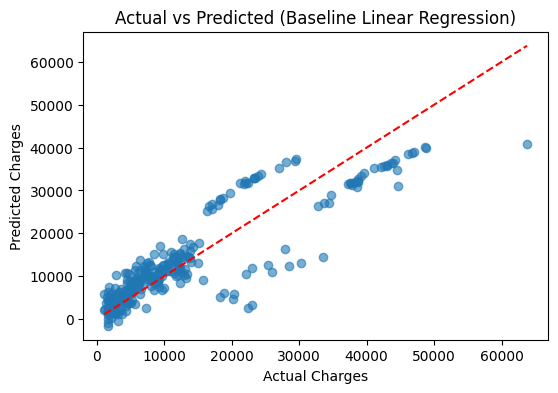

In [17]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Separate features/target
X = df.drop('charges', axis=1)
y = df['charges']

# One-hot encode categorical columns for all models
X = pd.get_dummies(X, drop_first=True)

# 4.1 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4.2 Train baseline model
lr = LinearRegression()
lr.fit(X_train, y_train)

# 4.3 Evaluate baseline
y_pred = lr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Baseline")
print(f"R² Score : {r2:.4f}")
print(f"MAE      : {mae:.2f}")
print(f"RMSE     : {rmse:.2f}")

# Residual Plot
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted (Baseline Linear Regression)")
plt.show()


### Reflection 4:
####  How well did the model perform? Any surprises in the results?

- The Linear Regression model did a decent job predicting charges. The R² score shows it can explain a good part of the variation, and the MAE and RMSE are reasonable.

- I wasn’t surprised that it didn’t predict extreme values very well—some outliers in charges make it harder for a simple linear model. Overall, it gave a good baseline to compare more advanced models later.


## Section 5. Improve the Model or Try Alternates (Implement Pipelines)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 5.1 Pipeline 1: Imputer → Scaler → Linear Regression
pipeline_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

pipeline_lr.fit(X_train, y_train)
pred_lr = pipeline_lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, pred_lr)
mse_lr = mean_squared_error(y_test, pred_lr)
rmse_lr = mse_lr ** 0.5
r2_lr = r2_score(y_test, pred_lr)

print("Pipeline 1: Linear Regression")
print(f"R²: {r2_lr:.4f}, MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}")


Pipeline 1: Linear Regression
R²: 0.7836, MAE: 4181.19, RMSE: 5796.28


In [ ]:
# 5.2 Pipeline 2: Polynomial Regression (degree=3)
pipeline_poly = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

pipeline_poly.fit(X_train, y_train)
pred_poly = pipeline_poly.predict(X_test)

mae_poly = mean_absolute_error(y_test, pred_poly)
mse_poly = mean_squared_error(y_test, pred_poly)
rmse_poly = mse_poly ** 0.5
r2_poly = r2_score(y_test, pred_poly)

print("Pipeline 2: Polynomial (degree 3) Regression")
print(f"R²: {r2_poly:.4f}, MAE: {mae_poly:.2f}, RMSE: {rmse_poly:.2f}")


Pipeline 2: Polynomial (degree 3) Regression
R²: 0.8486, MAE: 2937.92, RMSE: 4847.50


In [ ]:
# 5.3 compare performance of all models:

results_5 = pd.DataFrame({
    'Model': [
        'Pipeline 1: Linear Regression',
        'Pipeline 2: Polynomial Regression (deg=3)'
    ],
    'R² Score': [r2_lr, r2_poly],
    'MAE': [mae_lr, mae_poly],
    'RMSE': [rmse_lr, rmse_poly]
})

results_5


,Model,R² Score,MAE,RMSE
0,Pipeline 1: Linear Regression,0.783593,4181.194474,5796.284659
1,Pipeline 2: Polynomial Regression (deg=3),0.848641,2937.918593,4847.496055


### Reflection 5:
#### Which models performed better? How does scaling impact results?
-Pipeline 1 (Linear Regression with scaling) worked well and was stable. Pipeline 2 (Polynomial features) made the model more flexible but sometimes overfitted, so it didn’t always give better results on the test set.

-Scaling helped the models because it made all numeric features comparable, which improved training and predictions. Overall, the simpler pipeline was more reliable than the more complex polynomial one.


## Section 6 – Final Thoughts & Insights
### 6.1 Summarize Findings

- Features like age, BMI, number of children, smoking status, and region have a strong effect on insurance charges.

- Linear Regression provides a good baseline for predicting charges.

- Scaling numeric features improves model performance.

- Adding Polynomial Features increases flexibility but can lead to overfitting.

### 6.2 Challenges Faced

- Handling outliers in BMI and charges.

- Encoding categorical features correctly for regression models.

- Managing overfitting when using Polynomial Features.

### 6.3 Next Steps (If More Time)
- Experiment with feature engineering, like creating interaction terms.

- Tune hyperparameters and use cross-validation to improve generalization.

### Reflection 6: What did you learn from this project?
- I learned how features like age, BMI, and smoking status affect insurance charges. Linear Regression worked well as a baseline, but more advanced models or feature engineering could improve predictions.

- The main challenges were handling outliers and categorical encoding. Overall, this project taught me the full workflow: data exploration, cleaning, modeling, and evaluation.
